In [2]:
import os
import re
import pandas as pd

data_path = 'data0924'
df = pd.DataFrame(columns=['no_array', 'no_node', 'no_worker', 'no_run', 'read_hit',
                  'read_miss', 'write_hit', 'write_miss', 'msi_runtime', 'rc_runtime'])
# 遍历data0910下所有子文件夹
for dir in os.listdir(data_path):
    # 解析文件夹名称
    no_array, no_node, no_worker, no_run = map(int, re.findall(r'\d+', dir))

    # 进入子文件夹
    dir_path = os.path.join(data_path, dir)
    files = os.listdir(dir_path)

    # 读取每个文件中的指标
    for file in files:
        with open(os.path.join(dir_path, file)) as f:
            content = f.read()

            if no_run == 1:

                read_hits = re.findall(r'read_hit: (\d+)', content)
                read_hit = sum(int(x) for x in read_hits)

                read_misses = re.findall(r'read_miss: (\d+)', content)
                read_miss = sum(int(x) for x in read_misses)

                write_hits = re.findall(r'write_hit: (\d+)', content)
                write_hit = sum(int(x) for x in write_hits)

                write_misses = re.findall(r'write_miss: (\d+)', content)
                write_miss = sum(int(x) for x in write_misses)
                rc_runtime = -1

                msi_runtime = re.search(r'running time : (\d+)', content)

                if msi_runtime:
                    msi_runtime = int(msi_runtime.group(1))

            if no_run == 2:
                
                read_hits = re.findall(r'read_hit: (\d+)', content)
                read_hit = sum(int(x) for x in read_hits)

                read_misses = re.findall(r'read_miss: (\d+)', content)
                read_miss = sum(int(x) for x in read_misses)

                write_hits = re.findall(r'write_hit: (\d+)', content)
                write_hit = sum(int(x) for x in write_hits)

                write_misses = re.findall(r'write_miss: (\d+)', content)
                write_miss = sum(int(x) for x in write_misses)

                msi_runtime = -1

                rc_runtime = re.search(r'running time : (\d+)', content)

                if rc_runtime:
                    rc_runtime = int(rc_runtime.group(1))

            # 构造每行数据
            data = {
                'no_array': no_array,
                'no_node': no_node,
                'no_worker': no_worker,
                'no_run': no_run,
                'read_hit': read_hit,
                'read_miss': read_miss,
                'write_hit': write_hit,
                'write_miss': write_miss,
                'msi_runtime': msi_runtime,
                'rc_runtime': rc_runtime
            }
            # 添加到DataFrame
            # df = df.append(data, ignore_index=True)
            df2 = pd.DataFrame(data, index=[0])
            df = pd.concat([df, df2], ignore_index=True)
            # FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

# excel
df.to_excel('data0924_2.xlsx', index=False)

In [3]:

# 对no_array,no_node,no_worker,no_run相同的数据行进行求和，并且只保留一行数据
df = pd.read_excel('data0924_2.xlsx')
df= df.groupby(['no_array', 'no_node', 'no_worker', 'no_run']).sum().reset_index()
df.to_excel('data0924_3.xlsx', index=False)

In [4]:
# 计算read_miss/(read_hit+read_miss)
df = pd.read_excel('data0924_3.xlsx')
df['read_miss_rate'] = df['read_miss'] / (df['read_hit'] + df['read_miss'])
# 计算write_miss/(write_hit+write_miss)
df['write_miss_rate'] = df['write_miss'] / (df['write_hit'] + df['write_miss'])

# excel
df.to_excel('data0924_4.xlsx', index=False)

In [5]:
# 对相同no_array,no_node的两行数据，no_run==1的msi_runtime除以no_run==2的rc_runtime，命名为speed_ratio,放在no_run==2的行中
df=pd.read_excel('data0924_4.xlsx')
# 遍历每一行，当no_run==2时，计算speed_ratio
for i in range(len(df)):
    if df.loc[i,'no_run']==2:
        df.loc[i,'speed_ratio']=df.loc[i-1,'msi_runtime']/df.loc[i,'rc_runtime']
# excel
df.to_excel('data0924_5.xlsx', index=False)

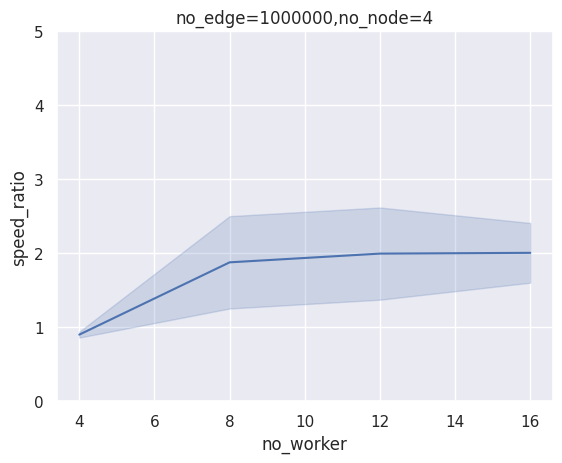

<Figure size 640x480 with 0 Axes>

In [6]:
# x: no_workr
# y：speed_ratio
# 绘图
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_excel('data0924_5.xlsx')
sns.set(style="darkgrid")
sns.lineplot(x="no_worker", y="speed_ratio", data=df)
# 标题为：no_array=1024,no_node=4
plt.ylim(0, 5)
plt.title('no_edge=1000000,no_node=4')
plt.show()
# save
plt.savefig('data0924_5.png')


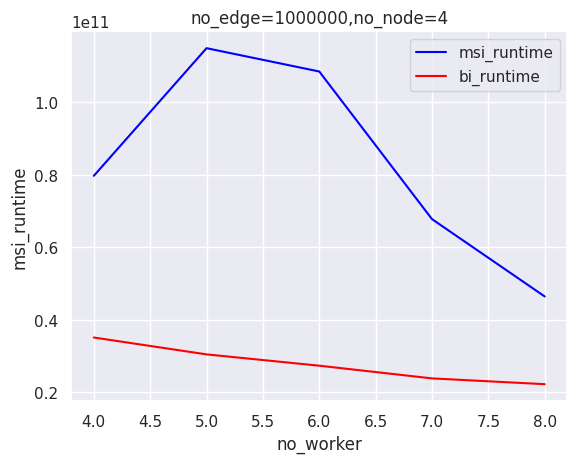

In [28]:
plt.clf()
sns.set(style="darkgrid")
sns.lineplot(x="no_worker", y="msi_runtime", data=df[df['msi_runtime']>0], color='blue', label='msi_runtime')
sns.lineplot(x="no_worker", y="rc_runtime", data=df[df['rc_runtime']>0], color='red', label='bi_runtime')
# 标题为：no_array=1024,no_node=4
plt.title('no_edge=1000000,no_node=4')
plt.show()

<Figure size 640x480 with 0 Axes>

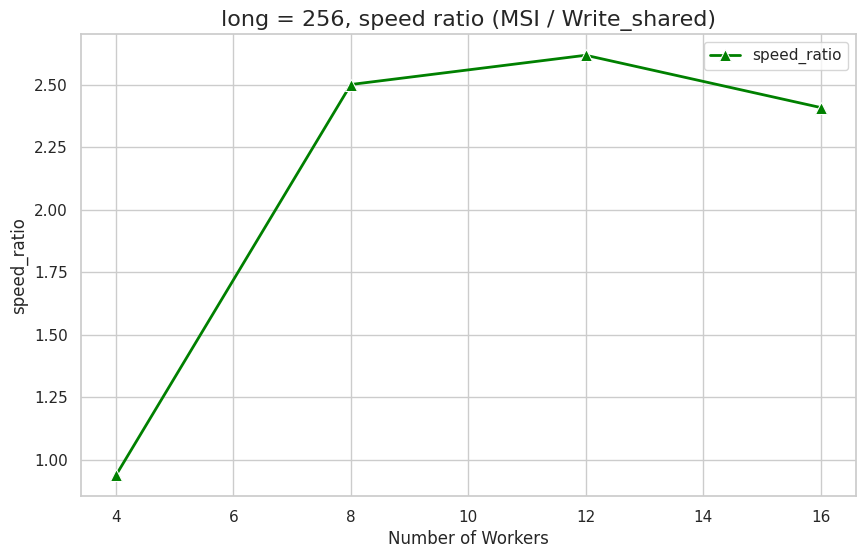

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_excel('data0924_5.xlsx')

plt.clf()
sns.set(style="whitegrid")

# 创建图形
plt.figure(figsize=(10, 6))

# 绘制 y1 和 y3（no_run==1）的曲线
df1 = df[(df['no_run'] == 2) & (df['no_array'] == 256)]
sns.lineplot(x="no_worker", y="speed_ratio", data=df1, label='speed_ratio', linestyle='-', linewidth=2, color='green', marker='^', markersize=8)

# 绘制 y2 和 y4（no_run==2）的曲线，使用不同线条样式和颜色，以突出对比
# df2 = df[(df['no_run'] == 2) & (df['no_array'] == 512)]
# sns.lineplot(x="no_worker", y="rc_runtime", data=df2, label='write_shared', linestyle='--', linewidth=2, color='red', marker='s', markersize=8)

# 添加图例
plt.legend()

# 添加标题和标签
plt.title('long = 256, speed ratio (MSI / Write_shared)', fontsize=16)
# plt.title('long = 512, running time (MSI vs Write_shared)', fontsize=16)
plt.xlabel('Number of Workers', fontsize=12)
plt.ylabel('speed_ratio', fontsize=12)

# 保存图像
plt.savefig('256_speed_ratio.png', dpi=300, bbox_inches='tight')

# 显示图表
plt.show()